<a href="https://colab.research.google.com/github/janaahmeed/codealpha_tasks/blob/main/code_Alpha_task2_(Emotion_Recognition_from_Speech_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn
import joblib

After framing, each frame is multiplied by a Hamming window to reduce spectral leakage before silence detection and further feature extraction.  
# When you use librosa.feature.mfcc, framing + windowing (Hamming) are already applied internally by default.

y>> the audio time-series signal , Compute MFCC features from audio signal lf sampled at fs Hz
y(t) = audio_signal
mfcc(y=audio_signal)

Always join files with root, never dirs.

In [93]:

import random
import librosa
import numpy as np
def apply_random_augmentation(signal, sr):
    augmentations = ["none", "stretch", "shift", "pitch", "noise"]
    choice = random.choice(augmentations)

    noise_factor = 0.005

    if choice == "noise":
        noise_factor = 0.005
        signal = signal + np.random.randn(len(signal)) * noise_factor

    elif choice == "stretch":
        rate = np.random.uniform(0.8, 1.2)
        signal = librosa.effects.time_stretch(signal, rate=rate)

    elif choice == "shift":
        shift = int(np.random.uniform(-0.2, 0.2) * len(signal))
        signal = np.roll(signal, shift)

    elif choice == "pitch":
        signal = librosa.effects.pitch_shift(
            signal,
            sr=sr,
            n_steps=np.random.uniform(-2, 2)
        )

    return signal



def load_audio(path, sr=22050):
    signal, sr = librosa.load(path, sr=sr ,duration=3.0)

    signal = apply_random_augmentation(signal, sr)

    return signal, sr


In [100]:
#
import os
import kagglehub

DATA_FILE = "ravdess-emotional-speech-audio"

if os.path.exists(DATA_FILE):
    print("Loading cached features...")

    x, y ,speakers = joblib.load(DATA_FILE)

else:
    print("Processing images (one-time)...")

# Download latest version
    path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")


    print("Path to dataset files:", path)
    x,y, speakers=[],[],[]





for root, dirs, files in os.walk(path):
    for _file in files:
        if _file.endswith(".wav"):
            file_path = os.path.join(root, _file)
            aug_data ,sr  =load_audio(file_path )

            y_trimmed, _ = librosa.effects.trim(aug_data ,top_db=25 )  # 20–30 is common for speech

            mfccs = librosa.feature.mfcc(
                y=y_trimmed,
                sr=sr ,
                n_mfcc=20,
                n_fft= 150,
                hop_length=512,
                window='hamming')
            mfccs = mfccs.T # (time_steps, n_mfcc)
            # Why? LSTM expects time dimension first

            x.append(mfccs)
            emo_str = _file.split("-")[2]

            y.append(emo_str)




joblib.dump((x, y ,speakers), DATA_FILE)
print("Features saved.")
#(n_mfcc, time_frames) >>shape mfcc


#NumPy arrays require equal shapes
#Your MFCCs are variable-length sequences >> so we neednot ( Pad for CNN / Use sequence models (LSTM) / Use tf.keras.preprocessing.sequence.pad_sequences)
#“Don’t force uniform shape — store each MFCC as a separate object” if duration is fixed we donot need for it
#so type object
x = np.array(x, dtype=object)
y = np.array(y)

print(x.shape, y.shape)




Processing images (one-time)...
Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio
Features saved.
(2880,) (2880,)


In [101]:
print("X shape:", x.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))
print("Random baseline:", 1 / len(np.unique(y)))


X shape: (2880,)
y shape: (2880,)
Unique labels: ['01' '02' '03' '04' '05' '06' '07' '08']
Random baseline: 0.125


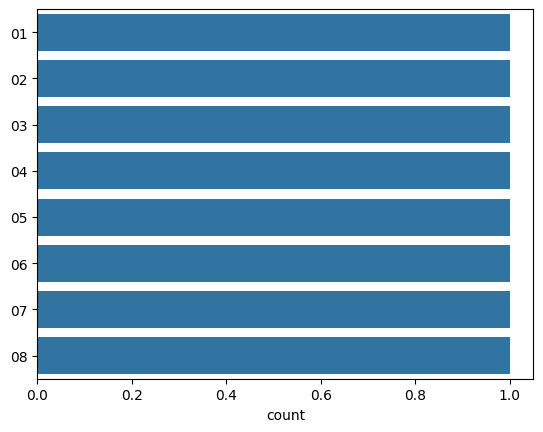

In [102]:
import seaborn as sns
sns.countplot(np.unique(y))
plt.show()

In [103]:
import tensorflow as tf
x=tf.keras.preprocessing.sequence.pad_sequences(
    x ,
    maxlen=150,
    dtype='float32',
    padding='post',
    truncating='post')

#for conv2d new dimansion to adapt MFCC inputs for convolutional layers.
x=x[..., np.newaxis]


In [106]:
x.shape

(2880, 150, 20, 1)

//CNN / LSTM

In [104]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
#y_encoded = to_categorical(y_encoded ,num_classes=7)

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x,y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)






In [127]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test  = (X_test  - X_train.mean()) / X_train.std()


MFCC features have limited frequency resolution, so aggressive pooling across both axes may collapse feature maps.
We therefore apply pooling mainly along the time axis and preserve frequency information.

model.add(Reshape((-1, x.shape[2] * 128)))
Why?

-1 lets Keras infer time steps automatically

Works even if you change pooling later

model.add(MaxPooling2D(pool_size=(1, 2)))
This:

reduces noise

keeps emotion dynamics

stabilizes LSTM learning

Frequency pooling:

smooths spectral noise

improves generalization

stabilizes training

In [163]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Bidirectional,
    Flatten, LSTM, Dense, Dropout, Reshape ,TimeDistributed ,GlobalAveragePooling1D
)

# Using the average emotion across time = stable
import numpy as np

model = Sequential()

# Input
model.add(Input(shape=(x.shape[1], x.shape[2], 1)))

# CNN block 1
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # optional
model.add(BatchNormalization())
model.add(Dropout(0.2))

# CNN block 2
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # optional
model.add(BatchNormalization())
model.add(Dropout(0.2))


# Prepare for LSTM >> flattten inseadreshape (frq * channels )
model.add(TimeDistributed(Flatten()))

# LSTM blocks
model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(256, return_sequences=False)))

model.add(Dropout(0.3))

#model.add(GlobalAveragePooling1D())

# Output
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-6 ),  # safer learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 150, 20, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 75, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 75, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 75, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 75, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 37, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 37, 5, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 37, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 37, 640)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ (None, 37, 256)        │       787,456 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 512)            │     1,050,624 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,917,448 (7.31 MB)

 Trainable params: 1,917,064 (7.31 MB)

 Non-trainable params: 384 (1.50 KB)

-(batch, 7) from LSTM
-matches output with sparse_categorical_crossentropy


In [110]:
print(y_test.dtype)

int64


In [111]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [154]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [135]:
print("Train labels:", np.unique(y_train))
print("Test labels:", np.unique(y_test))
print("Num classes:", len(np.unique(y)))
print("Speakers:", len(set(speakers)))


Train labels: [0 1 2 3 4 5 6 7]
Test labels: [0 1 2 3 4 5 6 7]
Num classes: 8
Speakers: 0


In [158]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.875), 1: np.float64(0.9375), 2: np.float64(0.9375), 3: np.float64(0.9375), 4: np.float64(0.9375), 5: np.float64(0.9375), 6: np.float64(0.9375), 7: np.float64(0.9375)}


In [165]:
model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=8,
    batch_size=64,
   class_weight=class_weights,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1322 - loss: 2.1015 - val_accuracy: 0.1645 - val_loss: 2.0846
Epoch 2/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1368 - loss: 2.0974 - val_accuracy: 0.1645 - val_loss: 2.0846
Epoch 3/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1391 - loss: 2.0979 - val_accuracy: 0.1645 - val_loss: 2.0844
Epoch 4/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1241 - loss: 2.0918 - val_accuracy: 0.1645 - val_loss: 2.0849
Epoch 5/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1348 - loss: 2.0797 - val_accuracy: 0.1645 - val_loss: 2.0865
Epoch 6/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1355 - loss: 2.0978 - val_accuracy: 0.1558 - val_loss: 2.0886


In [166]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1027 - loss: 2.1301
Test Accuracy: 0.1181


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


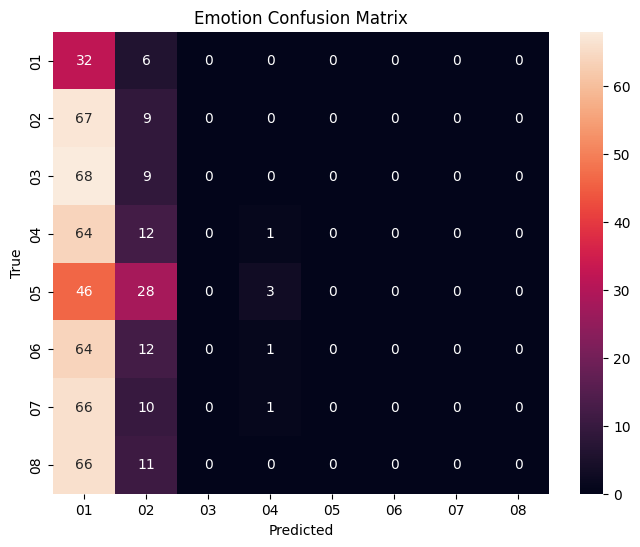

In [117]:
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Emotion Confusion Matrix")
plt.show()


In [119]:
X_train.shape


(2304, 150, 20, 1)